In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import pandas as pd
from torch.nn import Sequential, ReLU, Linear, Conv1d, LSTM, RNN, Dropout
from torch.nn import Module
from torch.optim import Adam, SGD
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor   
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import ml_confs

from NCP.model import DeepSVD
from NCP.layers import SingularLayer, MLPOperator

np.random.seed(0)
torch.manual_seed(0)
Ntrain = 10000
Nval = 1000
Ntest = 1000

# torch.set_default_dtype(torch.float64)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# device = 'cpu'

cuda:0


In [3]:
import wandb
wandb.login()

wandb: Currently logged in as: gturri. Use `wandb login --relogin` to force relogin


True

In [3]:
X = np.random.uniform(-1, 1, Ntrain+Nval+Ntest)
Y = X + np.random.normal(0, .1, X.shape[0])

X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

xscaler = StandardScaler()
yscaler = StandardScaler()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=Ntest, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=Nval, random_state=0)

X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)
X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)

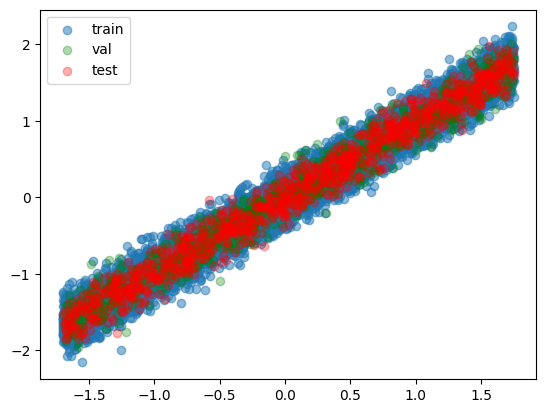

In [4]:
plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [6]:
np.random.seed(0)
torch.manual_seed(0)

config = {
    'input_shape': X_train.shape[-1],
    'output_shape': 20,
    'n_hidden': 2,
    'layer_size': 64,
    'lr': 1e-3,
    'gamma': .01,
    'epochs': 2e3,
}

# wandb.init(project='NCP_linear', config=config)
# config = wandb.config
config = ml_confs.from_dict(config)

U_operator = MLPOperator(config.input_shape, config.n_hidden, config.layer_size, config.output_shape)
V_operator = MLPOperator(config.input_shape, config.n_hidden, config.layer_size, config.output_shape)

optimizer = Adam
optimizer_kwargs = {
    'lr': config.lr
    }
reg = DeepSVD(U_operator, V_operator, config.output_shape, gamma=config.gamma, device=device)

In [7]:
reg.fit(X_train, Y_train, X_val, Y_val, epochs=int(config.epochs), optimizer=optimizer, optimizer_kwargs=optimizer_kwargs)
# reg.fit(X_train, Y_train, X_val, Y_val, epochs=int(config.epochs), optimizer=optimizer, optimizer_kwargs=optimizer_kwargs, wandb=wandb)

epoch = 1999, loss = -5.102815628051758: 100%|██████████| 2000/2000 [00:22<00:00, 87.67it/s] 


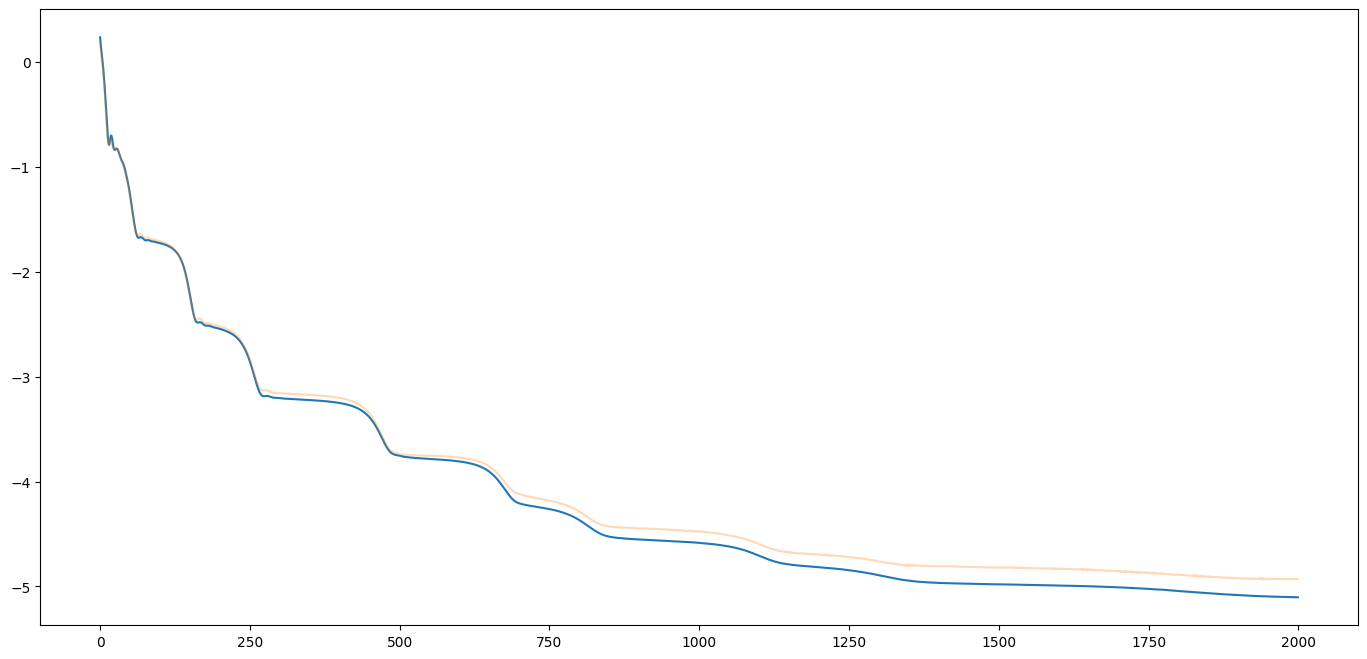

In [8]:
ls = reg.get_losses()
plt.figure(figsize=(17, 8))
plt.plot(range(len(ls)), np.array(ls))
plt.plot(range(len(ls)), np.array(reg.get_val_losses()), alpha=0.3)
# plt.yscale('log')
plt.show()

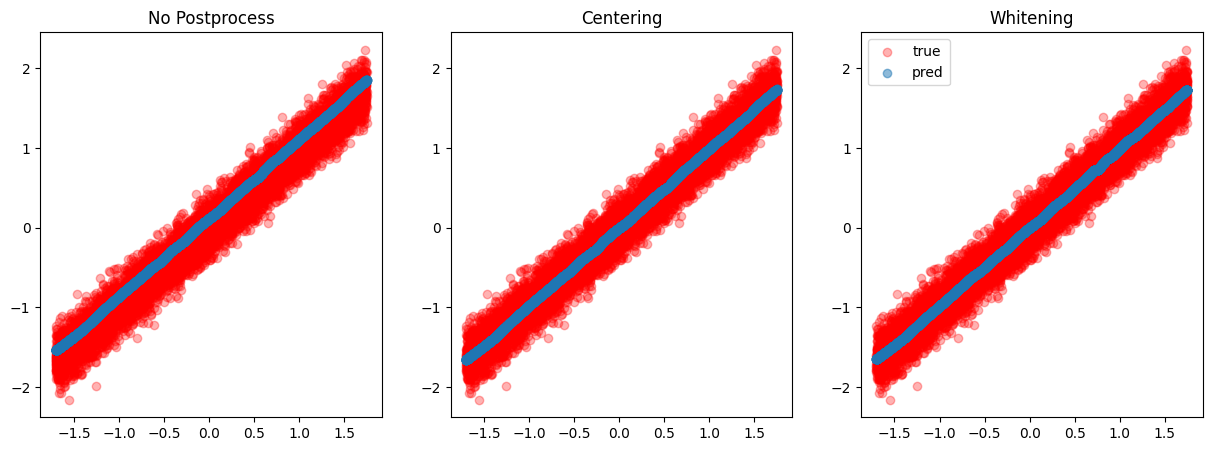

In [11]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

ax=axs[0]
pred = reg.predict(X_train, postprocessing=None).reshape(-1, 1)
ax.scatter(X_train, Y_train, color='r', alpha=0.3, label='true')
ax.scatter(X_train, pred, alpha=0.5, label = 'pred')
ax.set_title('No Postprocess')

ax=axs[1]
pred = reg.predict(X_train, postprocessing='centering').reshape(-1, 1)
ax.scatter(X_train, Y_train, color='r', alpha=0.3, label='true')
ax.scatter(X_train, pred, alpha=0.5, label = 'pred')
ax.set_title('Centering')

ax=axs[2]
pred = reg.predict(X_train, postprocessing='whitening').reshape(-1, 1)
ax.scatter(X_train, Y_train, color='r', alpha=0.3, label='true')
ax.scatter(X_train, pred, alpha=0.5, label = 'pred')
ax.set_title('Whitening')

plt.legend()
plt.show()

In [12]:
torch.sqrt(torch.exp(-reg.models['S'].weights ** 2))

tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9993, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000], device='cuda:0', grad_fn=<SqrtBackward0>)

In [13]:
interval_A = np.array([-1, 1])
interval_B = np.array([-1, 1])

In [14]:
reg.joint_probability(interval_A, interval_B, postprocessing=True)

1.742020070552826

In [15]:
reg.conditional_probability(interval_A, interval_B, postprocessing=True)

1.0178622787475586

In [16]:
reg.joint_probability(interval_A, interval_B, postprocessing=False)

AttributeError: 'DeepSVD' object has no attribute 'postprocess_UV_tmp'

In [17]:
reg.conditional_probability(interval_A, interval_B, postprocessing=False)

AttributeError: 'DeepSVD' object has no attribute 'postprocess_UV_tmp'

In [15]:
from NCP.model import indicator_fn
n = Y_train.shape[0]
y_B = indicator_fn(Y_train, interval_B)
x_A = indicator_fn(X_train, interval_A)

joint_prob = (x_A*y_B).mean()*(x_A.mean() ** -1)*(y_B.mean() ** -1)
print(joint_prob)

1.6078403039729756


In [56]:
pred_df = pd.DataFrame({
    'X': X_test.squeeze(),
    'Y_true': Y_test.squeeze(), 
    'Y_pred': pred.squeeze()
})
wandb.log({"predictions" : wandb.Table(dataframe=pred_df)})
wandb.log({"RMSE": np.mean((Y_test-pred)**2)**(1/2)})
wandb.finish()

RMSE,▁
train_loss,█▆▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
RMSE,0.08522
train_loss,-10.66979
val_loss,-10.38044


In [44]:
for module_name, module in reg.models.items():
    if module_name == 'S':
        print(module.weights)

Parameter containing:
tensor([ 1.5908e-09,  6.3601e-13,  2.5901e-01,  9.5637e-01,  2.6510e-03,
        -1.9210e-16,  1.6210e-05, -1.0114e+00, -1.2763e-13,  1.9427e-12],
       device='cuda:0', requires_grad=True)


In [12]:
def sqrtmh(A: torch.Tensor):
    # Credits to
    """Compute the square root of a Symmetric or Hermitian positive definite matrix or batch of matrices. Credits to  `https://github.com/pytorch/pytorch/issues/25481#issuecomment-1032789228 <https://github.com/pytorch/pytorch/issues/25481#issuecomment-1032789228>`_."""
    L, Q = torch.linalg.eigh(A)
    zero = torch.zeros((), device=L.device, dtype=L.dtype)
    threshold = L.max(-1).values * L.size(-1) * torch.finfo(L.dtype).eps
    L = L.where(L > threshold.unsqueeze(-1), zero)  # zero out small components
    return (Q * L.sqrt().unsqueeze(-2)) @ Q.mH

In [13]:
sigma = torch.sqrt(torch.exp(-reg.models['S'].weights**2))

In [14]:
n = X_train.shape[0]
eps = 2 * torch.finfo(torch.get_default_dtype()).eps

Ux = reg.models['U'](torch.Tensor(X_train).to(device))
Vy = reg.models['V'](torch.Tensor(Y_train).to(device))

if Ux.shape[-1] > 1:
    Ux = Ux - torch.outer(torch.mean(Ux, axis=-1), torch.ones(Ux.shape[-1], device=device))
    Vy = Vy - torch.outer(torch.mean(Vy, axis=-1), torch.ones(Vy.shape[-1], device=device))

Ux = Ux @ torch.diag(sigma)
Vy = Vy @ torch.diag(sigma)

cov_X = Ux.T @ Ux * n**-1
cov_Y = Vy.T @ Vy * n**-1
cov_XY = Ux.T @ Vy * n**-1

# write in a stable way
sqrt_cov_X_inv = torch.linalg.pinv(sqrtmh(cov_X))
sqrt_cov_Y_inv = torch.linalg.pinv(sqrtmh(cov_Y))

M = sqrt_cov_X_inv @ cov_XY @ sqrt_cov_Y_inv
# sing_vec_l, sing_val, sing_vec_r = torch.linalg.svd(M)
e_val, sing_vec_l = torch.linalg.eigh(M @ M.T)
sing_vec_l = sing_vec_l[:, e_val >= eps]
e_val= e_val[e_val >= eps]
print('e_val', e_val)
#sing_vec_l, sing_val, sing_vec_r = torch.svd(Ux.T @ Vy * n**-1)
sing_val = torch.sqrt(e_val)
sing_vec_r = (M.T @ sing_vec_l) / sing_val
print('sing val', sing_val)
print('sing_vec_l', sing_vec_l)
print('sing_vec_r', sing_vec_r)

# Ux = Ux - torch.outer(torch.mean(Ux, axis=-1), torch.ones(Ux.shape[-1], device=self.device))
# Vy = Vy - torch.outer(torch.mean(Vy, axis=-1), torch.ones(Vy.shape[-1], device=self.device))

Ux = (Ux @ sqrt_cov_X_inv @ sing_vec_l).detach().cpu().numpy()
Vy = (Vy @ sqrt_cov_Y_inv @ sing_vec_r).detach().cpu().numpy()

e_val tensor([0.9951, 1.0000], device='cuda:0', grad_fn=<IndexBackward0>)
sing val tensor([0.9975, 1.0000], device='cuda:0', grad_fn=<SqrtBackward0>)
sing_vec_l tensor([[ 0.2473,  0.0547],
        [ 0.2468,  0.0548],
        [-0.5334,  0.0523],
        [-0.0274, -0.8448],
        [-0.4685,  0.0881],
        [ 0.3676,  0.0491],
        [ 0.1930,  0.0573],
        [-0.0051,  0.5051],
        [-0.3031,  0.0804],
        [ 0.3301,  0.0509]], device='cuda:0', grad_fn=<IndexBackward0>)
sing_vec_r tensor([[ 0.3169, -0.0982],
        [ 0.3179, -0.0920],
        [-0.3313, -0.1514],
        [-0.0458, -0.3006],
        [-0.3709, -0.1611],
        [ 0.1884, -0.1100],
        [ 0.4206, -0.0887],
        [-0.0849,  0.8833],
        [-0.5305, -0.1757],
        [ 0.2192, -0.1072]], device='cuda:0', grad_fn=<DivBackward0>)


In [15]:
cov_X = Ux.T @ Ux / X_train.shape[0]
cov_Y = Vy.T @ Vy / X_train.shape[0]

In [16]:
cov_X

array([[9.9999994e-01, 3.9958954e-07],
       [3.9958954e-07, 1.0000006e+00]], dtype=float32)

In [17]:
np.linalg.eig(cov_X)

EigResult(eigenvalues=array([0.99999976, 1.0000008 ], dtype=float32), eigenvectors=array([[-0.9039544 , -0.42762884],
       [ 0.42762884, -0.9039544 ]], dtype=float32))

In [18]:
cov_Y

array([[ 9.9999976e-01, -1.9836426e-07],
       [-1.9836426e-07,  1.0000008e+00]], dtype=float32)

In [20]:
np.linalg.eig(cov_Y)

EigResult(eigenvalues=array([0.9999997, 1.0000008], dtype=float32), eigenvectors=array([[-0.9843601 ,  0.17616802],
       [-0.17616802, -0.9843601 ]], dtype=float32))

In [21]:
Ux.mean(0)

array([1.7538547e-05, 1.0000005e+00], dtype=float32)

In [22]:
Vy.mean(0)

array([1.7204404e-05, 1.0000008e+00], dtype=float32)